In [1]:
!pip install yfinance pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 12.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=317859 sha256=5e59081060df61f9a7e3983a8abc40a2d130d772d14bb341ec06745eee15b3fd
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# For reproducibility
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load TSLA data from YFinance
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-10-31'
tsla_data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [4]:
# Check for missing values
print(tsla_data.isnull().sum())

# Fill missing values (if any)
tsla_data.fillna(method='ffill', inplace=True)

# Extract 'Close' prices and scale (if necessary for LSTM)
close_prices = tsla_data['Adj Close']


Price      Ticker
Adj Close  TSLA      0
Close      TSLA      0
High       TSLA      0
Low        TSLA      0
Open       TSLA      0
Volume     TSLA      0
dtype: int64


In [5]:
# Filter the 'Close' column and reset index for compatibility with some models
tsla_data = tsla_data[['Adj Close']].reset_index()
tsla_data.columns = ['ds', 'y']


In [6]:
tsla_data.head()

,ds,y
0,2015-01-02 00:00:00+00:00,14.620667
1,2015-01-05 00:00:00+00:00,14.006000
2,2015-01-06 00:00:00+00:00,14.085333
3,2015-01-07 00:00:00+00:00,14.063333
4,2015-01-08 00:00:00+00:00,14.041333


In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model_arima = ARIMA(tsla_data['y'], order=(5,1,0))  # Example order
arima_fit = model_arima.fit()

# Print model summary
print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2474
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7906.790
Date:                Mon, 11 Nov 2024   AIC                          15825.580
Time:                        18:22:24   BIC                          15860.459
Sample:                             0   HQIC                         15838.249
                               - 2474                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0290      0.012     -2.322      0.020      -0.053      -0.005
ar.L2          0.0100      0.011      0.894      0.371      -0.012       0.032
ar.L3         -0.0024      0.014     -0.172      0.8

In [8]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(
            df[col], infer_datetime_format=True) 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [9]:
tsla_data = remove_tz_from_dataframe(tsla_data)

In [10]:
from prophet import Prophet

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(tsla_data)


18:22:25 - cmdstanpy - INFO - Chain [1] start processing
18:22:25 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Forecast period (6-12 months)
forecast_horizon = 365  # Adjust to 180 for 6 months if desired

# Create future dataframe
future_dates = prophet_model.make_future_dataframe(periods=forecast_horizon)

# Generate forecast
forecast = prophet_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2834,2025-10-26,222.417571,175.534171,273.241727
2835,2025-10-27,223.318777,175.160405,272.550334
2836,2025-10-28,223.060812,174.950001,270.923877
2837,2025-10-29,223.402434,177.340815,273.214285
2838,2025-10-30,222.983047,175.673399,273.815667


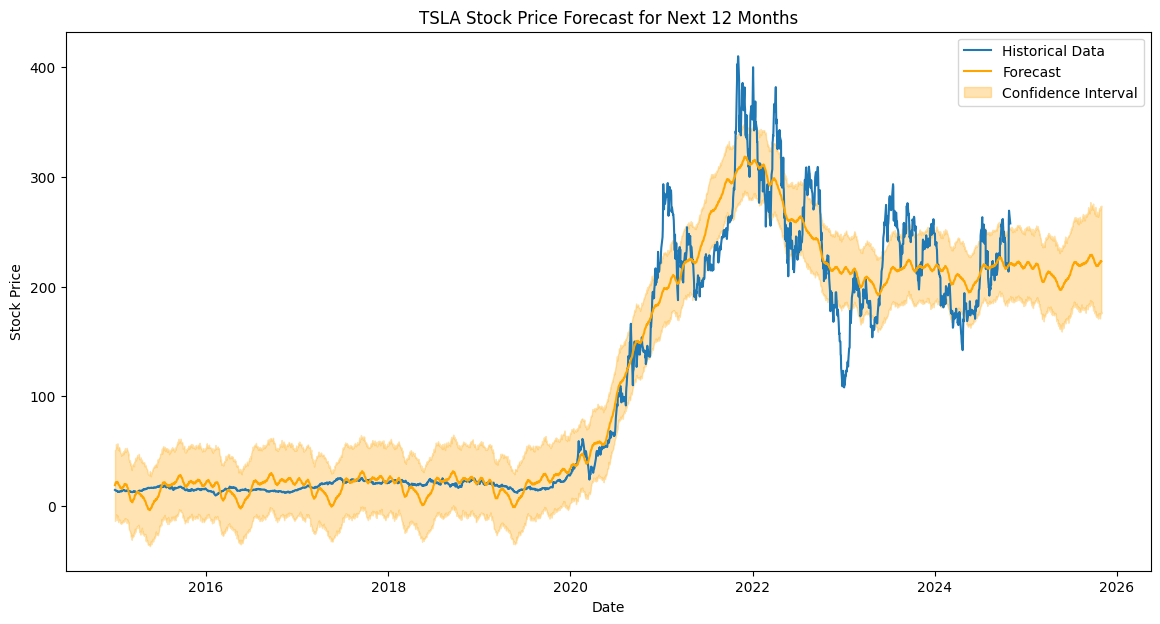

In [12]:
# Plot forecast with historical data
plt.figure(figsize=(14, 7))
plt.plot(tsla_data['ds'], tsla_data['y'], label="Historical Data")
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3, label="Confidence Interval")
plt.title(f"{ticker} Stock Price Forecast for Next {forecast_horizon//30} Months")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


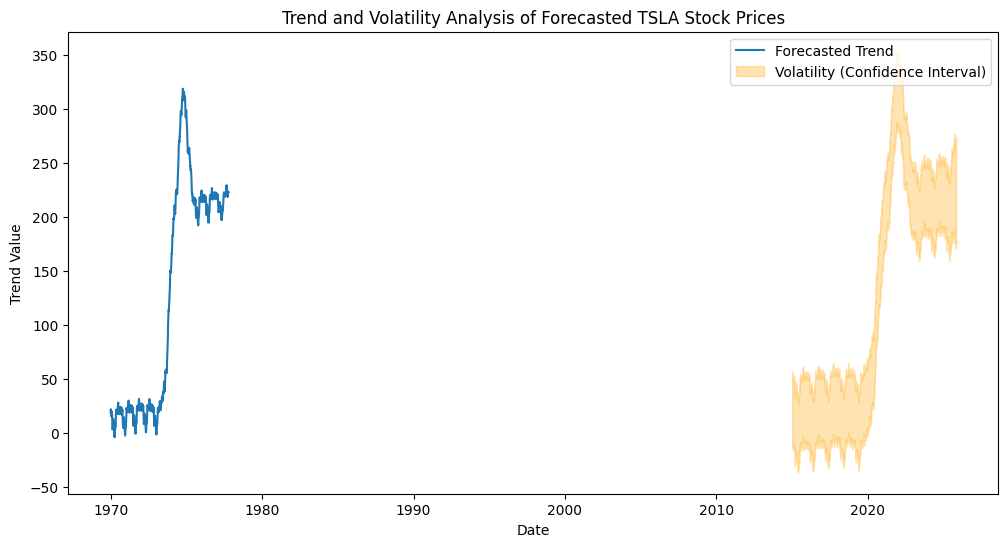

Forecasted Trend Volatility: 0.9593487315306551


In [13]:
# Extract trend components for deeper analysis if applicable
trend = forecast['yhat']
trend_diff = trend.diff()

# Plot trend and volatility
plt.figure(figsize=(12, 6))
plt.plot(trend, label="Forecasted Trend")
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3, label="Volatility (Confidence Interval)")
plt.xlabel("Date")
plt.ylabel("Trend Value")
plt.title("Trend and Volatility Analysis of Forecasted TSLA Stock Prices")
plt.legend()
plt.show()

# Summary of trend volatility
volatility = trend_diff.std()
print(f"Forecasted Trend Volatility: {volatility}")


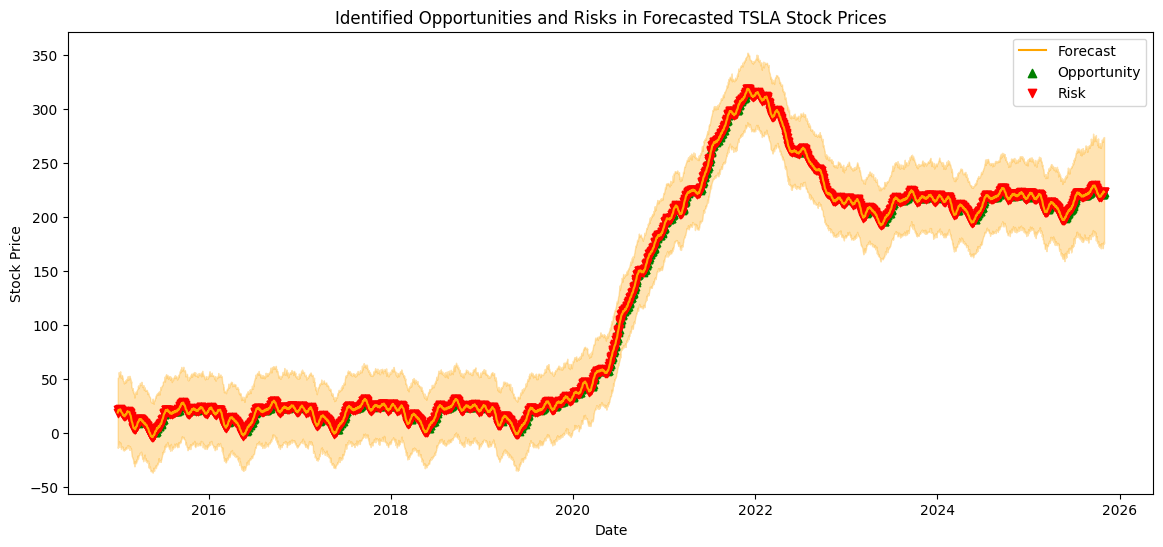

Potential Opportunity Periods:
             ds        yhat  yhat_upper
25   2015-02-09   19.860150   50.994649
27   2015-02-11   20.109847   52.713988
30   2015-02-17   19.657315   51.209293
54   2015-03-23    9.758298   40.809068
55   2015-03-24    9.870737   43.698462
...         ...         ...         ...
2832 2025-10-24  221.218989  270.394667
2833 2025-10-25  222.109657  269.875910
2834 2025-10-26  222.417571  273.241727
2835 2025-10-27  223.318777  272.550334
2837 2025-10-29  223.402434  273.214285

[930 rows x 3 columns]

Potential Risk Periods:
             ds        yhat  yhat_lower  yhat_upper
0    2015-01-02   19.018063  -13.608773   51.200070
1    2015-01-05   21.350735  -10.263503   51.629764
2    2015-01-06   21.161863  -11.210325   56.492579
3    2015-01-07   21.560731   -7.603859   54.161704
4    2015-01-08   21.182068   -9.127324   53.673067
...         ...         ...         ...         ...
2834 2025-10-26  222.417571  175.534171  273.241727
2835 2025-10-27  223.318

In [14]:
# Identify significant upward and downward trends
opportunity_periods = forecast[(trend_diff > 0) & (forecast['yhat'] > forecast['yhat'].rolling(20).mean())]
risk_periods = forecast[(trend_diff < 0) | (forecast['yhat_upper'] - forecast['yhat'] > volatility)]

# Plot opportunities and risks
plt.figure(figsize=(14, 6))
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.scatter(opportunity_periods['ds'], opportunity_periods['yhat'], color='green', label="Opportunity", marker='^')
plt.scatter(risk_periods['ds'], risk_periods['yhat'], color='red', label="Risk", marker='v')
plt.title("Identified Opportunities and Risks in Forecasted TSLA Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Print summary statistics
print(f"Potential Opportunity Periods:\n{opportunity_periods[['ds', 'yhat', 'yhat_upper']]}")
print(f"\nPotential Risk Periods:\n{risk_periods[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]}")
